<h1 align="center">Trabalho 2 - Sistema de Tráfego</h1>
<h3 align="center">Novembro, 2021</h3>

Inês Pires Presa - A90355  
Tiago dos Santos Silva Peixoto Carriço - A91695

## Análise do Problema:

### Descrição

Pretende-se criar um sistema de tráfego, representado por um grafo orientado em que os nodos representam pontos de acesso e os arcos denotam vias de comunicação só com um sentido. Após criar o grafo, tensiona-se determinar o maior número de vias que é possível remover mantendo o grafo ligado.

##Gerar o Sistema de Tráfego 

Para gerar o Sistema de Táfego começamos por criar um grafo direcionado utilizando a biblioteca NetworkX.  
Para garantir que o grafo é ligado decidimos começar por gerar um ciclo abrangendo todos os nodos ($N$) e, de seguida, adicionar aleatóriamente zero a dois descendentes a cada nodo.

In [ ]:
!pip install z3-solver

In [ ]:
import networkx as nx
from z3 import *
import random

In [ ]:
def gerar_grafo(N):
  grafo = nx.DiGraph()
  grafo.add_nodes_from([i for i in range(N)])

  for i in range(N-1):
    grafo.add_edge(i,i+1)
  grafo.add_edge(N-1, 0)

  for origem in range(N):
    numero_de_arestas = random.randint(0,2)
    lista_nodos = [i for i in range(N) if i != origem]
    for i in range(numero_de_arestas):
      indice = random.randint(0,len(lista_nodos)-1)
      destino = lista_nodos.pop(indice)
      grafo.add_edge(origem,destino)

  return grafo

In [ ]:
N = 32
grafo = gerar_grafo(N)

nx.draw(grafo, pos = nx.shell_layout(grafo) ,with_labels=True, node_size=400)

## Determinar o  Maior Número de Vias que é Possível Remover

Para resolver este problema utilizamos o solver z3. Começamos por criar uma variável $d_{e}$ que para cada aresta $e$, pertencente ao conjunto total de arestas ($E$), indica se a mesma é necessária para que o grafo se mantenha ligado.

De seguida, adicionamos, para cada par de nodos $(o,d)$, a condição que garante que entre dois nodos existe um caminho ($P_{o,d}$ é o conjunto de todos os caminhos entre $o$ e $d$):
$$\forall_{o\in N} \forall_{d \ne o \in N} \sum_{p \in P}( \textstyle\prod_{e \in p} d_{e} )$$ 

Finalmente, garantimos que o número de arestas que ficam no grafo é mínimo, ou seja, minimizamos a expressão:
$$\sum_{e\in E} d_{e}$$

In [ ]:
def path_edges(p):
  return [(p[i], p[i+1]) for i in range(len(p)-1)]

def manutencao(grafo, N):
  d = {}
  sol = Optimize()
  arestas = len(grafo.edges())
  for o,dest in grafo.edges():
    d[(o,dest)] = Int('d[(%i,%i)]' % (o,dest))
    sol.add(And(d[(o,dest)] >= 0,d[(o,dest)] <= 1))

  for o in grafo.nodes():
    for dest in grafo.nodes():
      if o != dest:
        lista = []
        for p in nx.all_simple_paths(grafo, o, dest):
          edges = path_edges(p)
          lista.append(Product([d[(a,b)] for a,b in edges]))
        sol.add(Sum(lista) >= 1)

  sol.minimize(sum([d[e] for e in grafo.edges()]))

  if sol.check() == sat:
    m = sol.model()
    for p in m.decls():
      string = p.name()[3:-2].split(',')
      if m[p].as_long() == 0:
        grafo.remove_edge(int(string[0]), int(string[1]))
    print("É possível remover " + str(arestas-len(grafo.edges())) + " arestas.")
  else:
    print("Nope")

manutencao(grafo, N)
nx.draw(grafo,pos = nx.shell_layout(grafo), with_labels=True, node_size=750)

##Exemplo 1:

N = 25

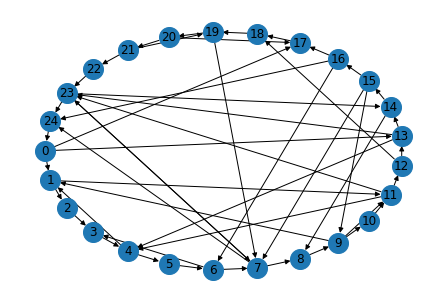

É possível remover 24 arestas.

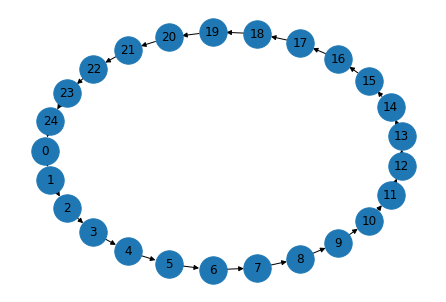




## Exemplo 2: 

Uma vez que não foi possível computar uma solução do problema para $N = 32$ em tempo concretizável, apresentamos a resposta exequível para $N=32$, ou seja, o caso em que cada nodo terá entre 1 a 2 descendentes.

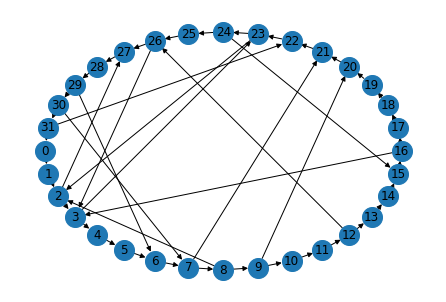

É possível remover 13 arestas.

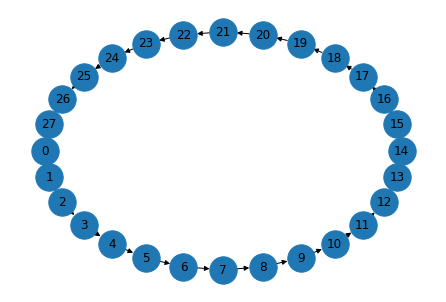